# Nearest neighbor for handwritten digit recognition

In this notebook we will build a classifier that takes an image of a handwritten digit and outputs a label 0-9. We will look at a particularly simple strategy for this problem known as the **nearest neighbor classifier**.

To run this notebook you should have the following Python packages installed:
* `numpy`
* `matplotlib`
* `sklearn`

## 1. The MNIST dataset

`MNIST` is a classic dataset in machine learning, consisting of 28x28 gray-scale images handwritten digits. The original training set contains 60,000 examples and the test set contains 10,000 examples. In this notebook we will be working with a subset of this data: a training set of 7,500 examples and a test set of 1,000 examples.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt 
import time

## Load the training set
train_data = np.load('MNIST/train_data.npy')
train_labels = np.load('MNIST/train_labels.npy')

## Load the testing set
test_data = np.load('MNIST/test_data.npy')
test_labels = np.load('MNIST/test_labels.npy')

In [2]:
## Print out their dimensions
print("Training dataset dimensions: ", np.shape(train_data))
print("Number of training labels: ", len(train_labels))
print("Testing dataset dimensions: ", np.shape(test_data))
print("Number of testing labels: ", len(test_labels))

Training dataset dimensions:  (7500, 784)
Number of training labels:  7500
Testing dataset dimensions:  (1000, 784)
Number of testing labels:  1000


In [3]:
## Compute the number of examples of each digit
train_digits, train_counts = np.unique(train_labels, return_counts=True)
print("Training set distribution:")
print(dict(zip(train_digits, train_counts)))

test_digits, test_counts = np.unique(test_labels, return_counts=True)
print("Test set distribution:")
print(dict(zip(test_digits, test_counts)))

Training set distribution:
{0: 750, 1: 750, 2: 750, 3: 750, 4: 750, 5: 750, 6: 750, 7: 750, 8: 750, 9: 750}
Test set distribution:
{0: 100, 1: 100, 2: 100, 3: 100, 4: 100, 5: 100, 6: 100, 7: 100, 8: 100, 9: 100}


## 2. Visualizing the data
Each data point is stored as 784-dimensional vector. To visualize a data point, we first reshape it to a 28x28 image.

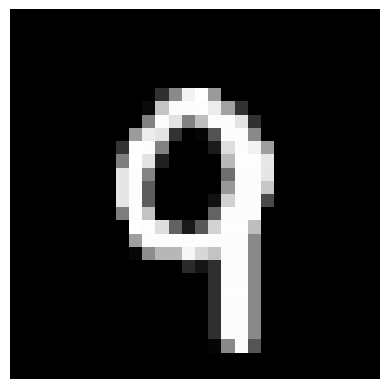

Label 9


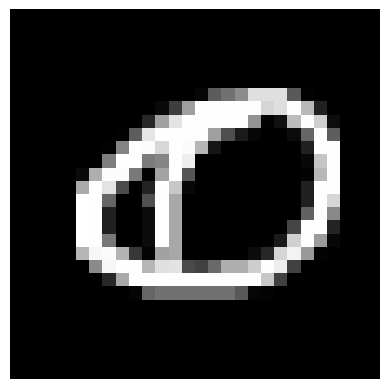

Label 0


In [4]:
## Define a function that displays a digit given its vector representation
def show_digit(x):
    plt.axis('off')
    plt.imshow(x.reshape((28,28)), cmap=plt.cm.gray)
    plt.show()
    return

## Define a function that takes an index into a particular data set ("train" or "test") and displays that image.
def vis_image(index, dataset="train"):
    if(dataset=="train"): 
        show_digit(train_data[index,])
        label = train_labels[index]
    else:
        show_digit(test_data[index,])
        label = test_labels[index]
    print("Label " + str(label))
    return

## View the first data point in the training set
vis_image(0, "train")

## Now view the first data point in the test set
vis_image(0, "test")

## 3. Squared Euclidean distance

To compute nearest neighbors in our data set, we need to first be able to compute distances between data points. A natural distance function is _Euclidean distance_: for two vectors $x, y \in \mathbb{R}^d$, their Euclidean distance is defined as 
$$\|x - y\| = \sqrt{\sum_{i=1}^d (x_i - y_i)^2}.$$
Often we omit the square root, and simply compute _squared Euclidean distance_:
$$\|x - y\|^2 = \sum_{i=1}^d (x_i - y_i)^2.$$
For the purposes of nearest neighbor computations, the two are equivalent: for three vectors $x, y, z \in \mathbb{R}^d$, we have $\|x - y\| \leq \|x - z\|$ if and only if $\|x - y\|^2 \leq \|x - z\|^2$.

Now we just need to be able to compute squared Euclidean distance. The following function does so.

In [5]:
## Computes squared Euclidean distance between two vectors.
def squared_dist(x,y):
    return np.sum(np.square(x-y))

## Compute distance between a seven and a one in our training set.
print("Distance from 7 to 1: ", squared_dist(train_data[4,],train_data[5,]))

## Compute distance between a seven and a two in our training set.
print("Distance from 7 to 2: ", squared_dist(train_data[4,],train_data[1,]))

## Compute distance between two seven's in our training set.
print("Distance from 7 to 7: ", squared_dist(train_data[4,],train_data[7,]))

Distance from 7 to 1:  5357193.0
Distance from 7 to 2:  12451684.0
Distance from 7 to 7:  5223403.0


## 4. Computing nearest neighbors

Now that we have a distance function defined, we can now turn to nearest neighbor classification. 

In [6]:
## Takes a vector x and returns the index of its nearest neighbor in train_data
def find_NN(x):
    # Compute distances from x to every row in train_data
    distances = [squared_dist(x,train_data[i,]) for i in range(len(train_labels))]
    # Get the index of the smallest distance
    return np.argmin(distances)

## Takes a vector x and returns the class of its nearest neighbor in train_data
def NN_classifier(x):
    # Get the index of the the nearest neighbor
    index = find_NN(x)
    # Return its class
    return train_labels[index]

A success case:
NN classification:  0
True label:  0
The test image:


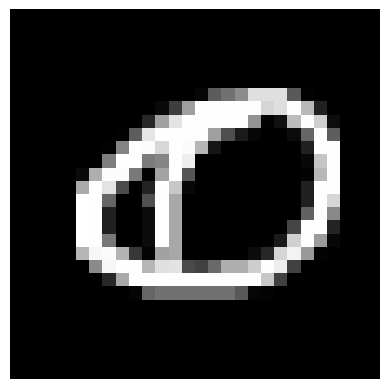

Label 0
The corresponding nearest neighbor image:


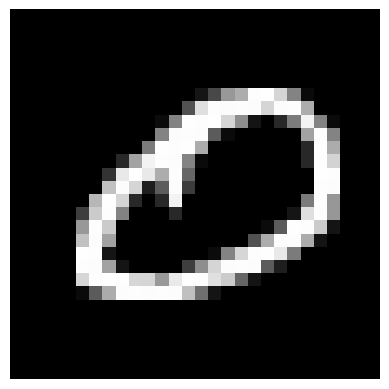

Label 0


In [7]:
## A success case:
print("A success case:")
print("NN classification: ", NN_classifier(test_data[0,]))
print("True label: ", test_labels[0])
print("The test image:")
vis_image(0, "test")
print("The corresponding nearest neighbor image:")
vis_image(find_NN(test_data[0,]), "train")

A failure case:
NN classification:  2
True label:  3
The test image:


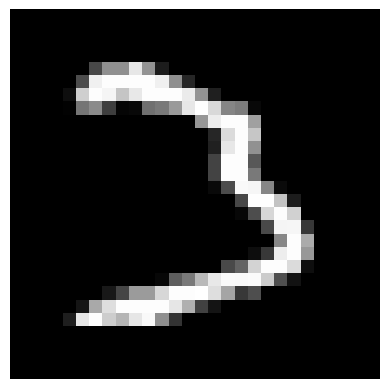

Label 3
The corresponding nearest neighbor image:


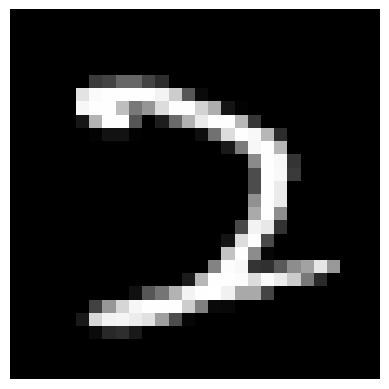

Label 2


In [8]:
## A failure case:
print("A failure case:")
print("NN classification: ", NN_classifier(test_data[39,]))
print("True label: ", test_labels[39])
print("The test image:")
vis_image(39, "test")
print("The corresponding nearest neighbor image:")
vis_image(find_NN(test_data[39,]), "train")

## 5. Processing the full test set

Now let's apply our nearest neighbor classifier over the full data set. 

Note that to classify each test point, our code takes a full pass over each of the 7500 training examples. Thus we should not expect testing to be very fast. The following code takes about 100-150 seconds on 2.6 GHz Intel Core i5. 

In [9]:
## Predict on each test data point (and time it!)
t_before = time.time()
test_predictions = [NN_classifier(test_data[i,]) for i in range(len(test_labels))]
t_after = time.time()

## Compute the error
err_positions = np.not_equal(test_predictions, test_labels)
error = float(np.sum(err_positions))/len(test_labels)

print("Error of nearest neighbor classifier: ", error)
print("Classification time (seconds): ", t_after - t_before)

Error of nearest neighbor classifier:  0.046
Classification time (seconds):  15.651563167572021


In [10]:
from sklearn.neighbors import BallTree

## Build nearest neighbor structure on training data
t_before = time.time()
ball_tree = BallTree(train_data)
t_after = time.time()

## Compute training time
t_training = t_after - t_before
print("Time to build data structure (seconds): ", t_training)

## Get nearest neighbor predictions on testing data
t_before = time.time()
test_neighbors = np.squeeze(ball_tree.query(test_data, k=1, return_distance=False))
ball_tree_predictions = train_labels[test_neighbors]
t_after = time.time()

## Compute testing time
t_testing = t_after - t_before
print("Time to classify test set (seconds): ", t_testing)

## Verify that the predictions are the same
print("Ball tree produces same predictions as above? ", np.array_equal(test_predictions, ball_tree_predictions))

Time to build data structure (seconds):  0.07914280891418457
Time to classify test set (seconds):  4.719163179397583
Ball tree produces same predictions as above?  True


In [11]:
from sklearn.neighbors import KDTree

## Build nearest neighbor structure on training data
t_before = time.time()
kd_tree = KDTree(train_data)
t_after = time.time()

## Compute training time
t_training = t_after - t_before
print("Time to build data structure (seconds): ", t_training)

## Get nearest neighbor predictions on testing data
t_before = time.time()
test_neighbors = np.squeeze(kd_tree.query(test_data, k=1, return_distance=False))
kd_tree_predictions = train_labels[test_neighbors]
t_after = time.time()

## Compute testing time
t_testing = t_after - t_before
print("Time to classify test set (seconds): ", t_testing)

## Verify that the predictions are the same
print("KD tree produces same predictions as above? ", np.array_equal(test_predictions, kd_tree_predictions))

Time to build data structure (seconds):  0.06798100471496582
Time to classify test set (seconds):  5.046020030975342
KD tree produces same predictions as above?  True


## HW1

Image 100:


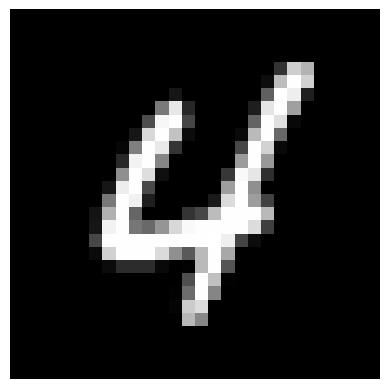

Label 4
Closest neighbor for img 100


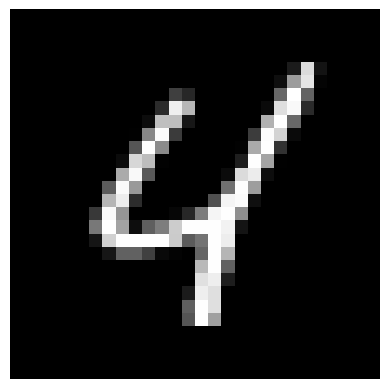

Label 4


In [12]:
# 8a
print("Image 100:")
vis_image(100, "test")
print("Closest neighbor for img 100")
vis_image(find_NN(test_data[100,]), "train")

In [13]:
#8b
from sklearn.metrics import confusion_matrix

def NN_test_label(x):
    label = find_NN(x)
    return train_labels[label]

pred_test_labels = list(map(NN_test_label, test_data))

confusion_matrix = confusion_matrix(test_labels, pred_test_labels)
print("L:  0   1   2   3   4   5   6   7   8   9")
print(confusion_matrix)

L:  0   1   2   3   4   5   6   7   8   9
[[ 99   0   0   0   0   1   0   0   0   0]
 [  0 100   0   0   0   0   0   0   0   0]
 [  0   1  94   1   0   0   0   3   1   0]
 [  0   0   2  91   2   4   0   0   1   0]
 [  0   0   0   0  97   0   0   0   0   3]
 [  1   0   0   0   0  98   0   0   0   1]
 [  0   0   0   0   0   1  99   0   0   0]
 [  0   4   0   0   1   0   0  94   0   1]
 [  2   0   1   1   1   0   1   1  92   1]
 [  1   1   1   1   2   1   0   3   0  90]]


In [24]:
#8c code
nn_indicies = list(map(find_NN, test_data))
avg_list = list(range(10))
for i in nn_indicies:
    l = train_labels[i]
    avg_list[l] += train_data[i]

for num in avg_list:
    avg_num = [x//100 for x in num]
    num = avg_num


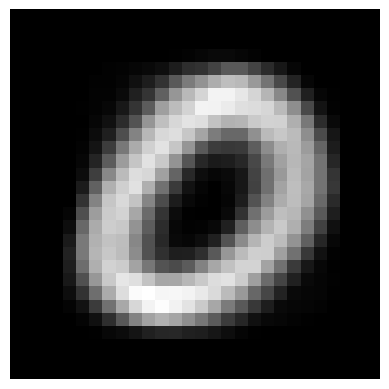

In [33]:
#show_digit(avg_list[8])
show_digit(avg_list[0])

In [118]:
# Load data set and code labels as 0 = ’NO’, 1 = ’DH’, 2 = ’SL’
labels = [b'NO', b'DH', b'SL']

data = np.loadtxt('spine-data.txt', converters={6: lambda s: labels.index(s)})

test_BP_raw = data[250:]
training_BP_raw = data[:250]

test_BP_labels = [inner[-1:] for inner in test_BP_raw]
test_BP_data = [inner[:-1] for inner in test_BP_raw]

train_BP_labels = [inner[-1:] for inner in training_BP_raw]
train_BP_data = [inner[:-1] for inner in training_BP_raw]

In [119]:
def squared_dist(x,y):
    return np.sum(np.square(x-y))

def lp1(x):
    distances = [np.sum(np.abs(x-train_BP_data[i])) for i in range(len(train_BP_labels))]
    return np.argmin(distances)

def lp2(x):
    distances = [squared_dist(x,train_BP_data[i]) for i in range(len(train_BP_labels))]
    return np.argmin(distances)

def lp1_classifier(x):
    index = lp1(x)
    return train_BP_labels[index]

def lp2_classifier(x):
    index = lp2(x)
    return train_BP_labels[index]

In [120]:

test_predictions_lp1 = [lp1_classifier(test_BP_data[i]) for i in range(len(test_BP_labels))]

err_positions = np.not_equal(test_predictions, test_BP_labels)
error = float(np.sum(err_positions))/len(test_BP_labels)

print("Error of lp1: ", error)

test_predictions = [lp2_classifier(test_BP_data[i]) for i in range(len(test_BP_labels))]

err_positions = np.not_equal(test_predictions, test_BP_labels)
error = float(np.sum(err_positions))/len(test_BP_labels)

print("Error of lp2: ", error)

Error of lp1:  0.21666666666666667
Error of lp2:  0.23333333333333334


In [122]:
from sklearn.metrics import confusion_matrix

pred_lp1_labels = [lp1_classifier(test_BP_data[i]) for i in range(len(test_BP_labels))]
pred_lp2_labels = [lp2_classifier(test_BP_data[i]) for i in range(len(test_BP_labels))]

confusion_matrix_lp1 = confusion_matrix(test_BP_labels, pred_lp1_labels)
confusion_matrix_lp2 = confusion_matrix(test_BP_labels, pred_lp2_labels)

print(confusion_matrix_lp1)
print(confusion_matrix_lp2)

[[14  0  2]
 [ 9  9  0]
 [ 1  1 24]]
[[12  1  3]
 [ 9  9  0]
 [ 1  0 25]]
